# Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 

import warnings
from IPython.display import display, HTML

In [2]:
display(HTML("<style>.container { width:70% !important; <style>}"))
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")

Загрузим данные

In [3]:
try:
    df_arc = pd.read_csv('E:/Data Science/final_steel/data_arc.csv')
    df_bulk = pd.read_csv('E:/Data Science/final_steel/data_bulk.csv')
    df_bulk_time = pd.read_csv('E:/Data Science/final_steel/data_bulk_time.csv')
    df_gas = pd.read_csv('E:/Data Science/final_steel/data_gas.csv')
    df_temp = pd.read_csv('E:/Data Science/final_steel/data_temp.csv')
    df_wire = pd.read_csv('E:/Data Science/final_steel/data_wire.csv')
    df_wire_time = pd.read_csv('E:/Data Science/final_steel/data_wire_time.csv')
except:
    df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')


# План проекта

1. Провести исследовательский анализ данных
2. Проверить данные на предмет наличия выбросов и решить, что с ними делать
3. Разобраться с пропущенными значениями в данных
4. Проверить наличие некорректных данных
5. Объединить исходные данные для возможности обучения модели
6. Разделить выборку на тестовую и тренировочную
7. Оценить качество полученных моделей и выбрать лучшую
8. Результат проделанной работы (Отчёт)

#  Исследовательский анализ данных

In [4]:
datasets = {
    'Данные об электродах':df_arc, 
    'Данные о подаче сыпучих материалов (объём)':df_bulk, 
    'Данные о подаче сыпучих материалов (время)':df_bulk_time,
    'Данные о продувке сплава газом':df_gas,
    'Результаты измерения температуры':df_temp,
    'Данные о проволочных материалах (объём)':df_wire,
    'Данные о проволочных материалах (время)':df_wire_time
}

In [5]:
for data in datasets:
    print(data)
    display(datasets[data].head(10))
    print()
    display(datasets[data].info())


Данные об электродах


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

Данные о подаче сыпучих материалов (объём)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

Данные о подаче сыпучих материалов (время)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

Данные о продувке сплава газом


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

Результаты измерения температуры


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

Данные о проволочных материалах (объём)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

Данные о проволочных материалах (время)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

- `data_arc.csv` — данные об электродах\
В данных отсутствуют пропуски, также с помощью реактивной и активной мощностей можно расчитать полную мощность. Произведение полной мощности на время нагрева даст энергию, затрачиваемую при нагреве.
- `data_bulk.csv`,`data_bulk_time.csv`,`data_wire.csv``data_wire_time.csv`\
В этих данных находится информация о времени и объёмах легирующих изначальный сплав добавках, присутствует большое количество пропусков, которые целесообразно заполнить нулями.
- `data_gas.csv` — данные о продувке сплава газом\
Содержит общее количественное значение о продувке сплава газом, пропуски отсутствуют.
- `data_temp.csv` — результаты измерения температуры\
Содержит время и замера и целевой признак исследования - температуру, имеется около 3000 пропусков, которые, вероятнее всего, придётся отбросить


### **Продолжим исследовать данные**

Построим по порядку "ящики с усами" для имеющихся данных

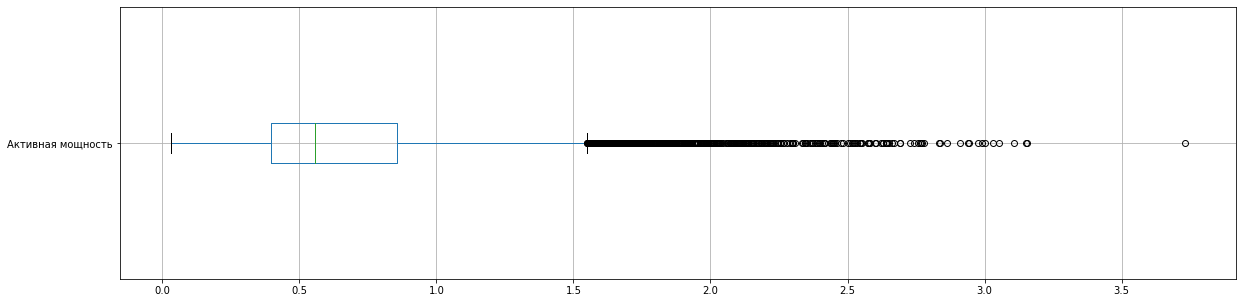

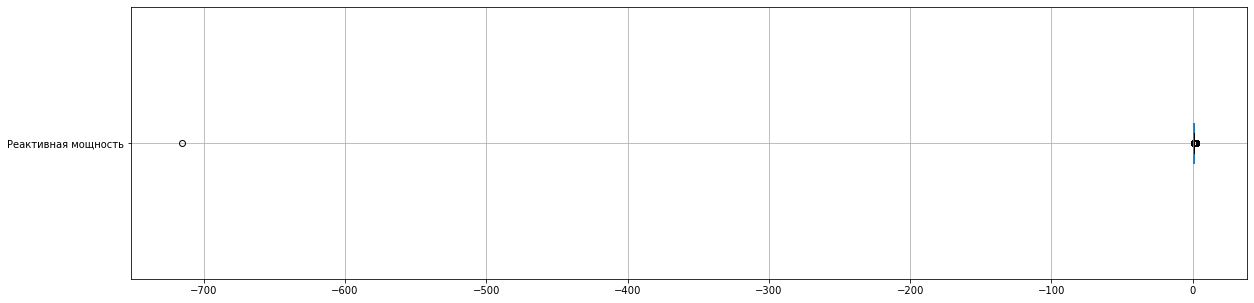

In [6]:
plt.figure(figsize=(20, 5))
df_arc.boxplot('Активная мощность', vert=False)
plt.show()

plt.figure(figsize=(20, 5))
df_arc.boxplot('Реактивная мощность', vert=False)
plt.show()

Видно наличие единичного выброса в реактивной мощности, для более корректной оценки сразу избавимся от него

In [7]:
df_arc = df_arc[df_arc['Реактивная мощность'] > 0]

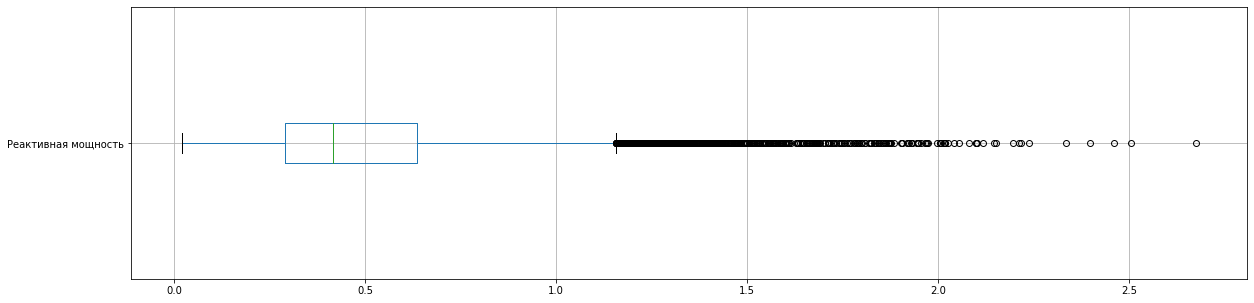

In [8]:
plt.figure(figsize=(20, 5))
df_arc.boxplot('Реактивная мощность', vert=False)
plt.show()

Также построим распределения для данных столбцов

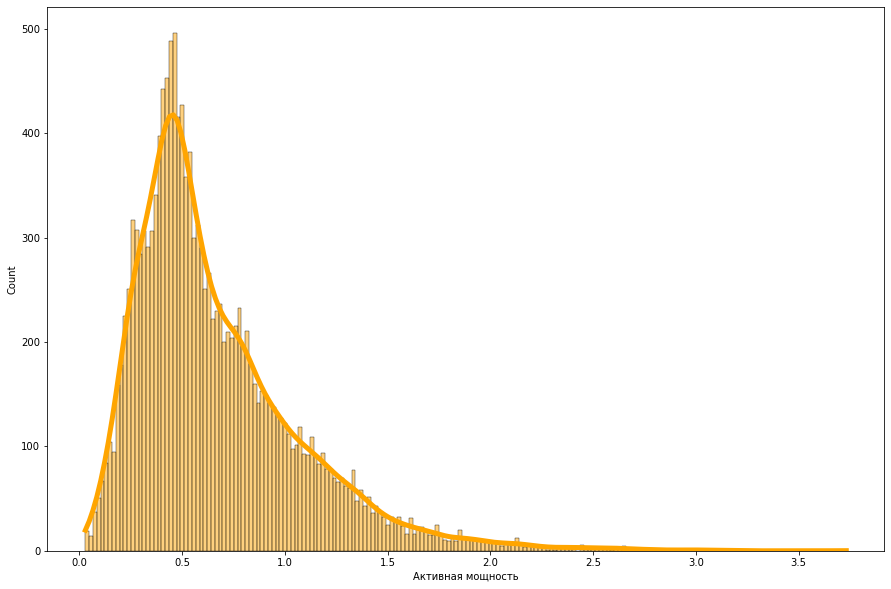

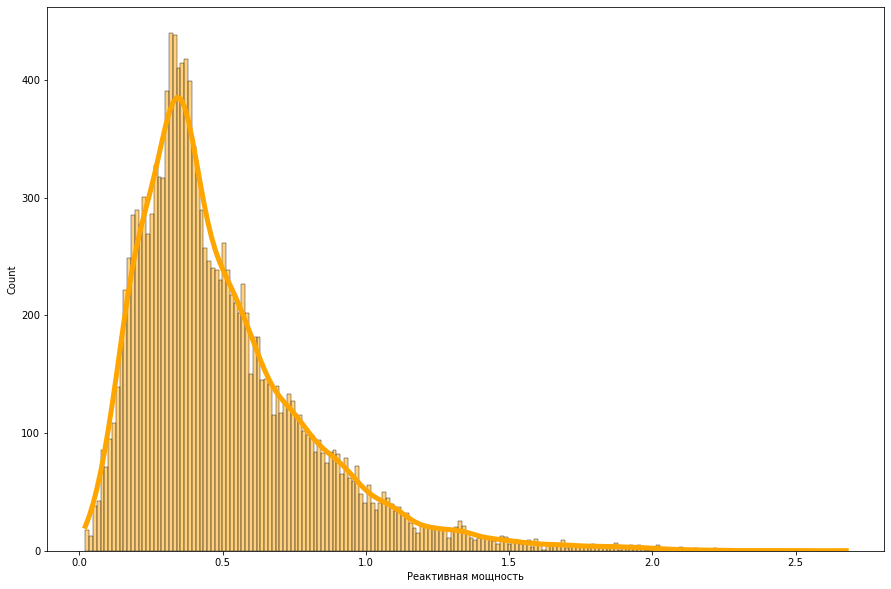

In [9]:
plt.figure(figsize=(15,10))
sns.histplot(df_arc['Активная мощность'], kde=True, line_kws = {'color': 'black', 'lw':5}, color='orange', bins = 200)
plt.show()

plt.figure(figsize=(15,10))
sns.histplot(df_arc['Реактивная мощность'], kde=True, line_kws = {'color' : 'black', 'lw':5}, bins = 200, color='orange')
plt.show()



По результатам анализа нужно узнать у заказчика, нужно ли оставить выбросы, является ли это каким-либо редкоиспользуемым режимом работы нагревательной конструкции, либо нужно от них избавиться.

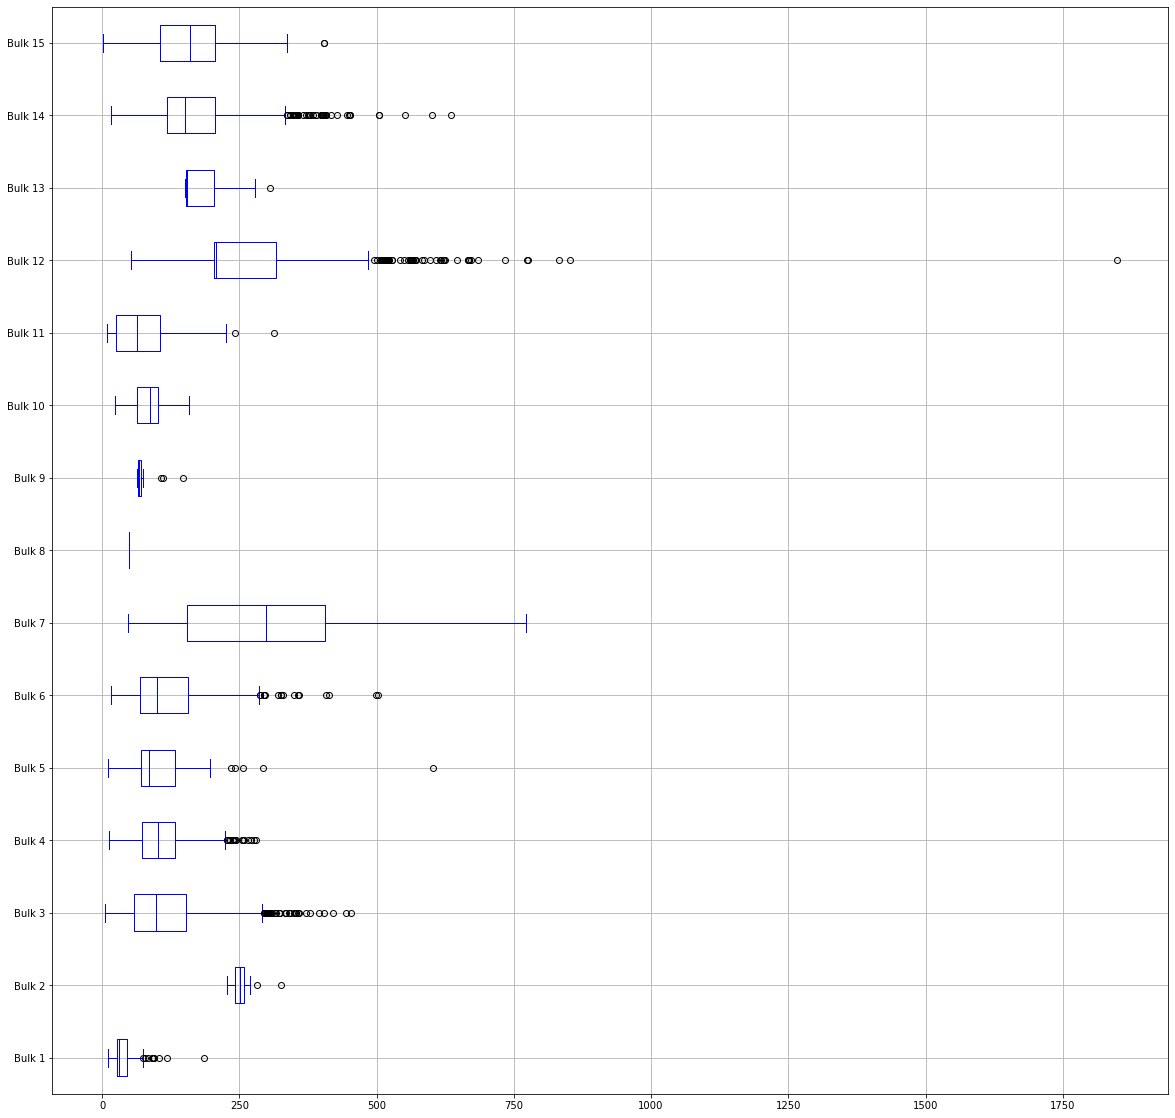

In [10]:
plt.figure(figsize=(20, 20))
df_bulk.boxplot([col for col in df_bulk.columns if col != 'key'], vert=False,color = 'Blue')
plt.show()

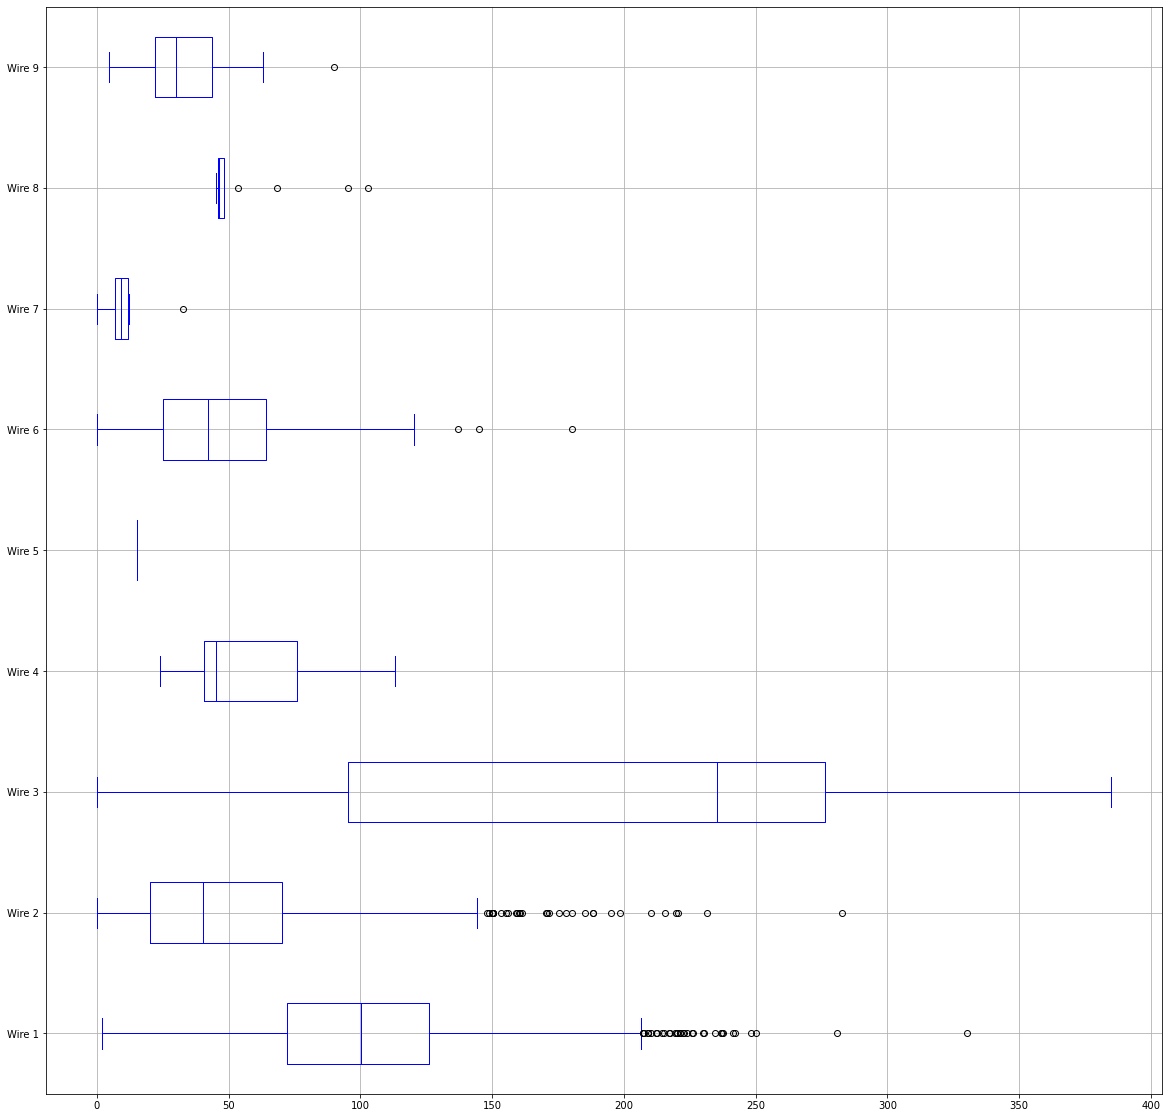

In [11]:
plt.figure(figsize=(20, 20))
df_wire.boxplot([col for col in df_wire.columns if col != 'key'], vert=False, color = 'Blue')
plt.show()

По полученным результатам можно сделать вывод о необходимости уточнить информацию по выбросам, так как они очень сконцентрированны, поэтому следует убедиться в необходимости от них избавиться, либо же принять как варианты создания редких сплавов

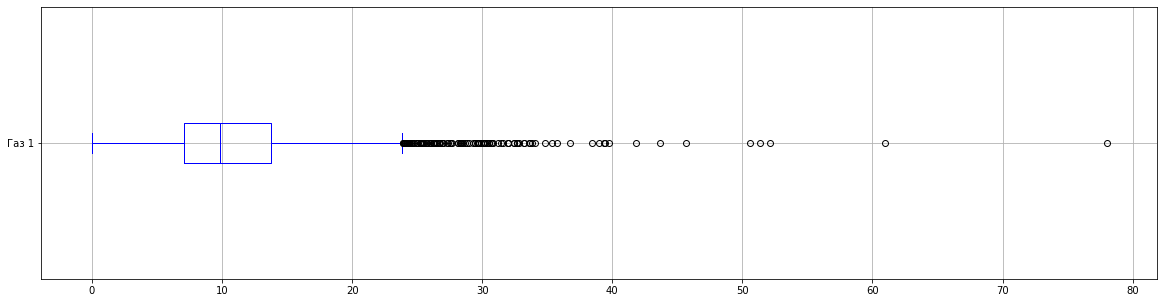

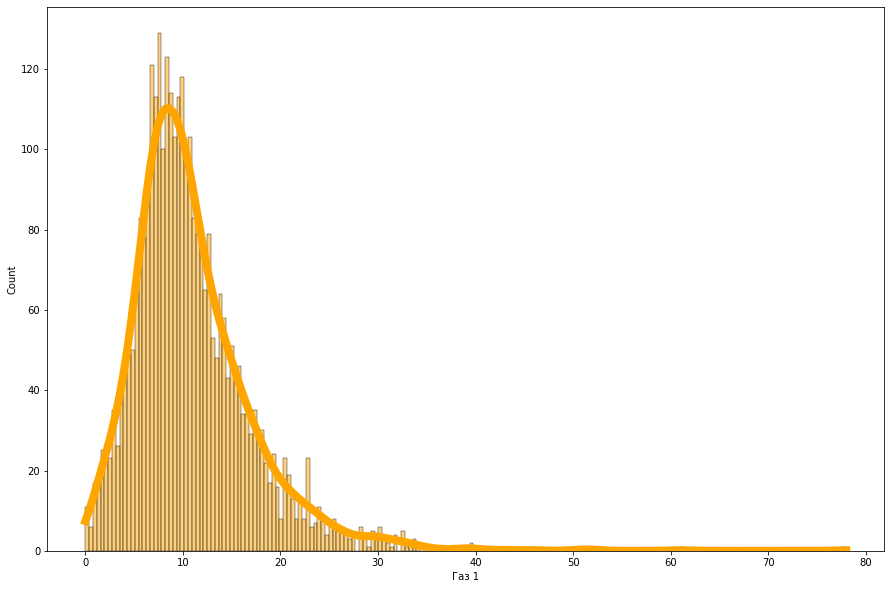

In [12]:
plt.figure(figsize=(20, 5))
df_gas.boxplot('Газ 1', vert=False, color = 'Blue')
plt.show()

plt.figure(figsize=(15,10))
sns.histplot(df_gas['Газ 1'], kde=True, line_kws={'lw':8}, bins = 200, color='orange')
plt.show()

По анологии с предыдущими данными есть ряд сконцентрированных значений, касаемо которых необходимо произвести уточнение

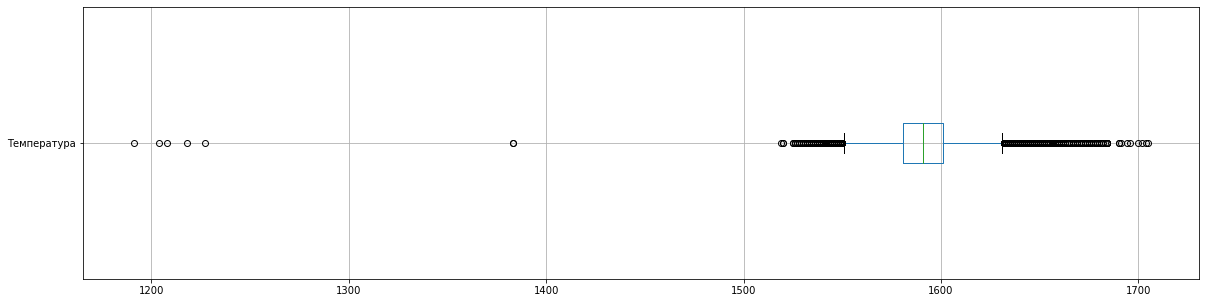

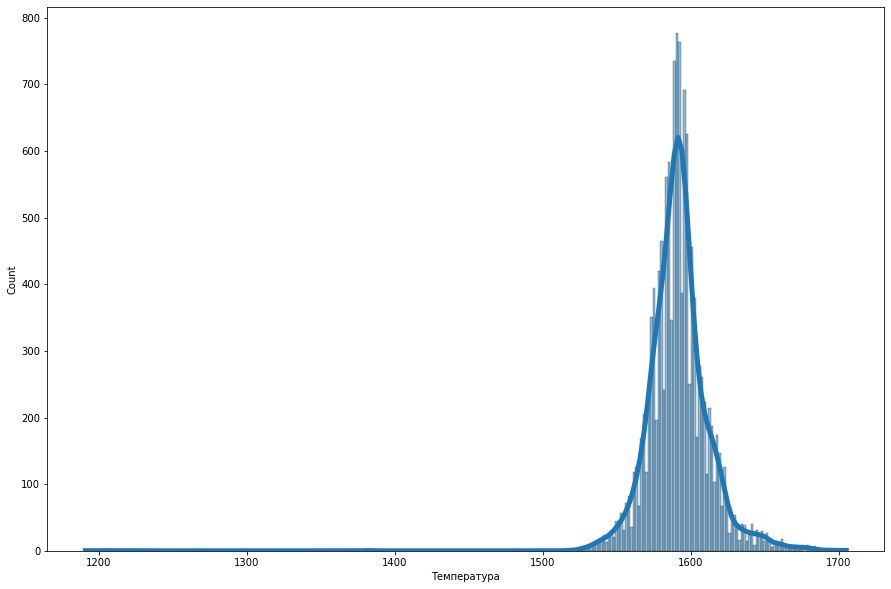

In [13]:
plt.figure(figsize=(20, 5))
df_temp.boxplot('Температура', vert=False)
plt.show()

plt.figure(figsize=(15,10))
sns.histplot(df_temp['Температура'], kde=True, line_kws={'lw':5})
plt.show()

In [14]:
df_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


По результатам исследования температуры можно сделать вывод о наличии большинства значений в диапазоне от 1500 до 1650, однако при наличии у заказчика информации, можно узнать более точный диапазон, который скорее всего нормирован документами, либо условиями эксплуатации. Также заметны просадки в histplot, которые указывают, что распределение не нормальное, возможно стоит **логарифмировать** значения

### Вывод

- `data_arc.csv`
- `data_bulk.csv`  
- `data_gas.csv`
- `data_temp.csv`
- `data_wire.csv`\
Касаемо перечисленных столбцов необходимо задать уточняющие вопросы заказчику по поводу некоторых выбросов, полученных в результате исследования данных \
`data_bulk.csv`, `data_wire.csv` пропуски в данных файлах необходимо заполнить нулями \
`data_temp.csv` - пропуски в данном датасете нужно устранить по результатам общения с заказчиком.




## Проверка корректности данных

Необходимо проверить данные на подчинение логике, а именно в таблице с целевым признаком удостовериться в том, что начальная температура ниже конечной, а также достоверность временной хронологии

In [15]:
# преобразовываем в нужный данные
df_temp['Время замера'] = pd.to_datetime(df_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')

# создаём сводную таблицу с последним измерением температуры 
df_temp_first = df_temp.groupby('key').agg('min')['Время замера']
df_temp_first = pd.DataFrame(df_temp_first)
df_temp_first = df_temp_first.merge(df_temp, on='Время замера', how='left')
df_temp_first.set_axis(['time_first','key','temp_first'], axis = 'columns', inplace = True)

# создаём сводную таблицу с первым измерением
df_temp_last = df_temp.groupby('key').agg('max')['Время замера']
df_temp_last = pd.DataFrame(df_temp_last)
df_temp_last = df_temp_last.merge(df_temp, on='Время замера', how='left')
df_temp_last.set_axis(['time_last','key','temp_last'], axis = 'columns', inplace = True)


df_check = df_temp_first.merge(df_temp_last, on='key', how='left')\
                  .reindex(columns=['key', 'time_first', 'temp_first', 'time_last', 'temp_last'])


Посмотрим полученный датасет

In [16]:
df_check.head(10)

,key,time_first,temp_first,time_last,temp_last
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0
5,6,2019-05-03 13:49:24,1543.0,2019-05-03 14:12:29,1596.0
6,7,2019-05-03 14:19:43,1586.0,2019-05-03 14:42:37,1599.0
7,8,2019-05-03 15:07:18,1577.0,2019-05-03 15:22:52,1598.0
8,9,2019-05-03 15:37:03,1587.0,2019-05-03 16:01:16,1592.0
9,10,2019-05-03 16:14:29,1574.0,2019-05-03 16:36:08,1593.0


In [17]:
print('Пропуски целевого признака',df_check['temp_last'].isna().sum())

Пропуски целевого признака 739


In [18]:
df_check = df_check.dropna()

Найдём число строк, которые не пройдут проверку

In [19]:
def check_time(row):
    return row['time_last'] >= row['max_time']

# 
def list_of_errors(list_of_data):
    data = df_check[['key', 'time_last']].merge(list_of_data[0], on='key', how='left')
    for dataset in list_of_data[1:]:
        data = data.merge(dataset, on='key', how='left')
    data['max_time'] = data.drop('key', axis=1).max(axis=1)
    data['check_error'] = data.apply(check_time, axis=1)
    keys = list(data[data['check_error'] == 0]['key'])
    return keys

In [20]:
# преобразуем тип данных
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

for col in df_bulk_time:
    if col != 'key':
        df_bulk_time[col] = pd.to_datetime(df_bulk_time[col], format='%Y-%m-%d %H:%M:%S')
        
for col in df_wire_time:
    if col != 'key':
        df_wire_time[col] = pd.to_datetime(df_wire_time[col], format='%Y-%m-%d %H:%M:%S')

# создадим сводную таблицу, где есть время крайнего нагерва 
df_arc_maxtime = pd.DataFrame(df_arc.groupby('key').agg('max')['Конец нагрева дугой'])
df_arc_maxtime.reset_index(inplace=True)

In [21]:
df_all_time = [df_arc_maxtime, df_bulk_time, df_wire_time]
keys_errors = list_of_errors(df_all_time)

print('Количество некорректных строк в данных',len(keys_errors))

Количество некорректных строк в данных 135


### Вывод

Некорректными оказалось 135 строк, от которых в последующих пунктах нужно избавиться.

## Вопросы заказчику

* Есть ли возможность заполнить пропуски в целевом признаке по какой-либо аналитической формуле? Или же стоит просто убрать пропуски?
* Стоит ли убирать все значения в данных, которые считаются выбросами при построении "ящика с усами"? Или же это редкие случаи работы предприятия  и их стоит оставить?
* Корректным ли будет добавить в качестве признака число добавок в сплав?
* Необходимо уточнить нормированный документацией диапазон температур при производстве, или можно принять таковым полученные данные в исследовании?
* Стоит ли добавить как признак полную мощность или энергию, затраченную на нагрев? (Можно рассчитать)
* Есть либо какие ещё "подводные камни", необходимые знать человеку, который впервые работает с такой категорией промышленности?
* Стоит ли добавить как признак время нагрева от первого замера до последнего?
* Какая метрика необходима в данной задаче и какое количественное значение она должна принять?
* Нужно ли учитывать время обучения модели в дальнейших этапах?

 <div style="background-color:MintCream; border:solid CadetBlue 2px; padding: 20px">
<b>Итоговый комментарий:</b>  Отличный план и вопросы. Готова его принять, как только ты исправишь пути к данным.
<div>

## Предобработка данных

Добавим дополнительный признак, а именно полную мощность по данным из `df_arc`:

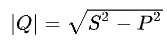

*Для справки: Часть полной мощности, которую удалось передать в нагрузку за период переменного тока, называется **активной мощностью** .Мощность, которая не была передана в нагрузку, а привела к потерям на нагрев и излучение, называется **реактивной мощностью**.*

In [22]:
df_arc['Полная мощность'] = (df_arc['Активная мощность'] ** 2 + df_arc['Реактивная мощность'] ** 2) ** (0.5)
df_arc['Время нагрева'] = (df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой'])
df_arc['Время нагрева'] = df_arc['Время нагрева'].apply(pd.Timedelta.total_seconds).astype('int')

In [23]:
df_arc.head(15)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,0.521549,137
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,1.574162,338
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,0.577638,126
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,0.975867,210
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494,1.256527,280


Объеденим полученные данные по столбцу `key`

In [24]:
df_arc_total = df_arc.groupby('key').sum()[['Время нагрева', 'Полная мощность']].reset_index()
df_arc_total.head(15)

,key,Время нагрева,Полная мощность
0,1,1098,5.826395
1,2,811,3.649216
2,3,655,2.989534
3,4,741,3.814962
4,5,869,4.035758
5,6,952,4.786837
6,7,673,2.987777
7,8,913,4.627389
8,9,625,2.555348
9,10,825,3.851739


In [25]:
def make_new_df(data, name):
    
    col_for_sum = []

    for col in data:
        if data[col].isna().sum() >= (len(data) - 0.70*len(data)):
            col_for_sum.append(col)
    
    data[f'count_{name}'] = data.drop('key', axis=1).count(axis=1)
    
    data[f'sum_{name}'] = data[col_for_sum].sum(axis=1)
    
    col_lasted = [col for col in data.columns if col not in col_for_sum]
    
    data = data[col_lasted].fillna(0)
    
    return data

In [26]:
df_bulk_feat = make_new_df(df_bulk, 'bulk')
df_wire_feat = make_new_df(df_wire, 'wire')

In [27]:
df_bulk_feat.head(15)


,key,Bulk 12,Bulk 14,Bulk 15,count_bulk,sum_bulk
0,1,206.0,150.0,154.0,4,43.0
1,2,206.0,149.0,154.0,4,73.0
2,3,205.0,152.0,153.0,4,34.0
3,4,207.0,153.0,154.0,4,81.0
4,5,203.0,151.0,152.0,4,78.0
5,6,204.0,201.0,154.0,4,117.0
6,7,204.0,152.0,154.0,4,117.0
7,8,410.0,252.0,153.0,4,99.0
8,9,107.0,99.0,203.0,4,117.0
9,10,203.0,102.0,204.0,3,0.0


In [28]:
len(df_bulk)

3129

In [29]:
df_wire_feat.head(15)

,key,Wire 1,count_wire,sum_wire
0,1,60.059998,1,0.000000
1,2,96.052315,1,0.000000
2,3,91.160157,1,0.000000
3,4,89.063515,1,0.000000
4,5,89.238236,2,9.114560
5,6,99.109917,2,9.114560
6,7,98.061600,1,0.000000
7,8,155.282394,1,0.000000
8,9,113.393279,2,9.143681
9,10,81.244796,2,12.376000


In [30]:
df_final = df_check.drop(['time_first', 'time_last'], axis=1)
df_final = df_final.merge(df_bulk_feat, on='key', how='left')
df_final = df_final.merge(df_wire_feat, on='key', how='left')
df_final = df_final.merge(df_arc_total[['key', 'Время нагрева', 'Полная мощность']], on='key', how='left')
df_final = df_final.merge(df_gas, on='key', how='left')
df_final = df_final.dropna()

df_final.info()
df_final.head(15)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2476
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              2329 non-null   int64  
 1   temp_first       2329 non-null   float64
 2   temp_last        2329 non-null   float64
 3   Bulk 12          2329 non-null   float64
 4   Bulk 14          2329 non-null   float64
 5   Bulk 15          2329 non-null   float64
 6   count_bulk       2329 non-null   float64
 7   sum_bulk         2329 non-null   float64
 8   Wire 1           2329 non-null   float64
 9   count_wire       2329 non-null   float64
 10  sum_wire         2329 non-null   float64
 11  Время нагрева    2329 non-null   float64
 12  Полная мощность  2329 non-null   float64
 13  Газ 1            2329 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 272.9 KB


,key,temp_first,temp_last,Bulk 12,Bulk 14,Bulk 15,count_bulk,sum_bulk,Wire 1,count_wire,sum_wire,Время нагрева,Полная мощность,Газ 1
0,1,1571.0,1613.0,206.0,150.0,154.0,4.0,43.0,60.059998,1.0,0.000000,1098.0,5.826395,29.749986
1,2,1581.0,1602.0,206.0,149.0,154.0,4.0,73.0,96.052315,1.0,0.000000,811.0,3.649216,12.555561
2,3,1596.0,1599.0,205.0,152.0,153.0,4.0,34.0,91.160157,1.0,0.000000,655.0,2.989534,28.554793
3,4,1601.0,1625.0,207.0,153.0,154.0,4.0,81.0,89.063515,1.0,0.000000,741.0,3.814962,18.841219
4,5,1576.0,1602.0,203.0,151.0,152.0,4.0,78.0,89.238236,2.0,9.114560,869.0,4.035758,5.413692
5,6,1543.0,1596.0,204.0,201.0,154.0,4.0,117.0,99.109917,2.0,9.114560,952.0,4.786837,11.273392
6,7,1586.0,1599.0,204.0,152.0,154.0,4.0,117.0,98.061600,1.0,0.000000,673.0,2.987777,9.836267
7,8,1577.0,1598.0,410.0,252.0,153.0,4.0,99.0,155.282394,1.0,0.000000,913.0,4.627389,15.171553
8,9,1587.0,1592.0,107.0,99.0,203.0,4.0,117.0,113.393279,2.0,9.143681,625.0,2.555348,8.216623
9,10,1574.0,1593.0,203.0,102.0,204.0,3.0,0.0,81.244796,2.0,12.376000,825.0,3.851739,6.529891


Уберём Температуры ниже 1400

In [31]:
df_final = df_final[df_final['temp_first'] >= 1400]

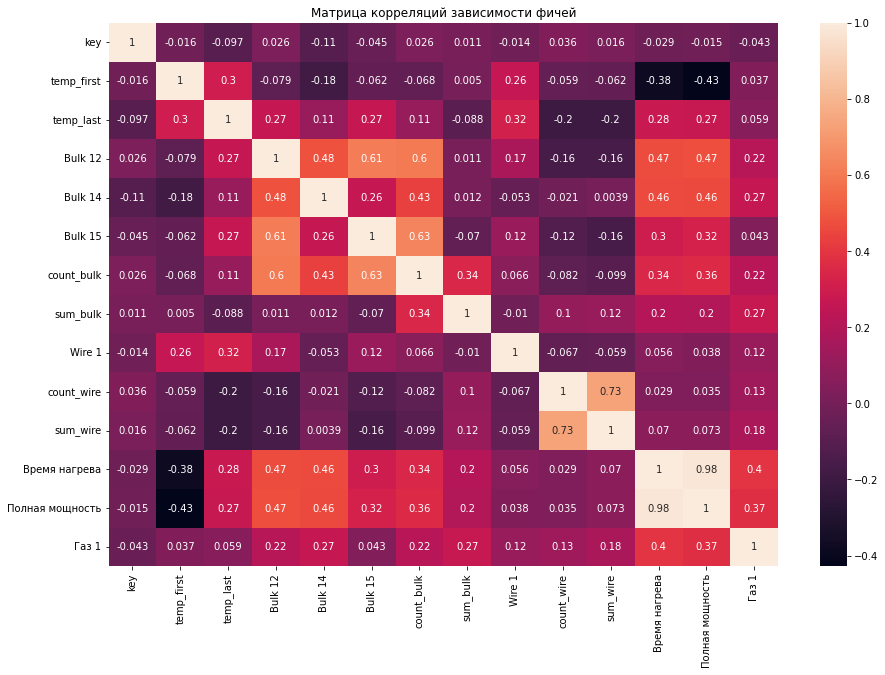

In [32]:
plt.figure(figsize=(15, 10))
plt.title('Матрица корреляций зависимости фичей')

sns.heatmap(df_final.corr(), annot = True)

plt.show()

Корреляция значений для полной мощности и времени нагрева достигает единицы, что очень плохо, поэтому посчитаем общую энергию и не будем учитывать время нагрева и полную мощность при обучении модели

In [33]:
df_final['Энергия'] = df_final['Время нагрева']*df_final['Полная мощность']

Была произведена предобработка данных, далее переходим к обучению модели

## Обучение моделей

Рассмотрим следующие модели обучения:
* XGBoost
* LightGBM
* CatBoost

In [34]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

from time import time

from sklearn.utils import shuffle

RANDOM_STATE = 13022023

Разделим выборки на обучающую и тестовую

In [35]:
df_shuffled = shuffle(df_final, random_state=RANDOM_STATE)

df_shuffled.info()

df_features = df_shuffled.drop(['key', 'temp_last', 'Время нагрева', 'Полная мощность'], axis=1)
df_target = df_shuffled['temp_last']

train_features, test_features, train_target, test_target = train_test_split(df_features, 
                                                                            df_target,
                                                                            test_size=0.25,
                                                                            random_state=RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 323 to 1613
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              2325 non-null   int64  
 1   temp_first       2325 non-null   float64
 2   temp_last        2325 non-null   float64
 3   Bulk 12          2325 non-null   float64
 4   Bulk 14          2325 non-null   float64
 5   Bulk 15          2325 non-null   float64
 6   count_bulk       2325 non-null   float64
 7   sum_bulk         2325 non-null   float64
 8   Wire 1           2325 non-null   float64
 9   count_wire       2325 non-null   float64
 10  sum_wire         2325 non-null   float64
 11  Время нагрева    2325 non-null   float64
 12  Полная мощность  2325 non-null   float64
 13  Газ 1            2325 non-null   float64
 14  Энергия          2325 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 290.6 KB


In [36]:
analisys = pd.DataFrame({'model':[], 'MAE_model':[], 'MAE_on_train':[], 'time_to_predict':[], 'time_to_fit':[]})
all_models = []

# создаём функцию для подбора параметров
def train_model(model, parameters):
    
    model_random = GridSearchCV(estimator=model,
                                param_grid=parameters, 
                                scoring='neg_mean_absolute_error',
                                cv=2, 
                                verbose=1)

    start = time()
    model_random.fit(train_features, train_target)
    print('GridSearchCV подбирал параметры %.2f секунд' %(time() - start))
    
    rmse = model_random.best_score_ * -1
    rmse_on_train = mean_absolute_error(train_target, model_random.predict(train_features))
    
    time_to_fit = model_random.cv_results_['mean_fit_time'][0]
    print('Время обучения модели %.2f секунд' %time_to_fit)
    
    time_to_predict = model_random.cv_results_['mean_score_time'][0]
    print('Модель предсказывает за %.2f секунд' %time_to_predict)
    
    print('Лучшие параметры:', model_random.best_params_)
    print('MAE обученной модели:', round(rmse,3))
    print('MAE на тренировочной выборке:', round(rmse_on_train,3))
       
    all_models.append(model_random)
    row = []
    row.extend([model, rmse, rmse_on_train,time_to_predict, time_to_fit])
    analisys.loc[len(analisys.index)] = row
    
    return model_random

### Обучим перечисленные ранее модели

### LigthGBM

In [37]:
rand_lgbm_param = {
    'max_depth': [5, 10, 15, 25, 35],
    'learning_rate': [0.01, 0.1, 0.15]
}

gbm = lgb.LGBMRegressor(boosting_type='gbdt',
                         objective = 'regression',
                         metric = 'RMSE')

gbm_random = train_model(gbm, rand_lgbm_param)

Fitting 2 folds for each of 15 candidates, totalling 30 fits
GridSearchCV подбирал параметры 1.55 секунд
Время обучения модели 0.04 секунд
Модель предсказывает за 0.00 секунд
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5}
MAE обученной модели: 6.236
MAE на тренировочной выборке: 4.256


### XGboost

In [38]:
rand_xgb_param = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
    'learning_rate': [0.1, 0.15, 0.3]
}

xb = xgb.XGBRegressor(booster='gbtree', 
                      eval_metric='rmse', 
                      use_rmm=True,
                     verbosity=0)

xb_random = train_model(xb, rand_xgb_param)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
GridSearchCV подбирал параметры 2.98 секунд
Время обучения модели 0.05 секунд
Модель предсказывает за 0.00 секунд
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 4}
MAE обученной модели: 6.069
MAE на тренировочной выборке: 4.596


### CatBoost

In [39]:
rand_cat_param = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.001, 0.01, 0.1]
}

cat = CatBoostRegressor(verbose=False) 

cat_random = train_model(cat, rand_cat_param)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
GridSearchCV подбирал параметры 51.88 секунд
Время обучения модели 0.60 секунд
Модель предсказывает за 0.03 секунд
Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 7}
MAE обученной модели: 6.026
MAE на тренировочной выборке: 4.629


,model,MAE_model,MAE_on_train,time_to_predict,time_to_fit,names
0,"LGBMRegressor(metric='RMSE', objective='regres...",6.235661,4.255991,0.002002,0.037033,LightGBM
1,"XGBRegressor(base_score=None, booster='gbtree'...",6.068708,4.595569,0.002502,0.046042,XGBoost
2,<catboost.core.CatBoostRegressor object at 0x0...,6.025926,4.629382,0.031028,0.603409,CatBoost


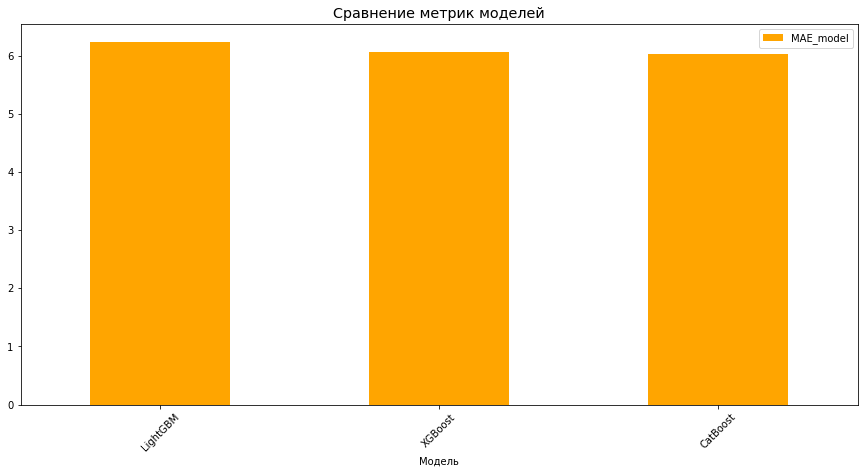

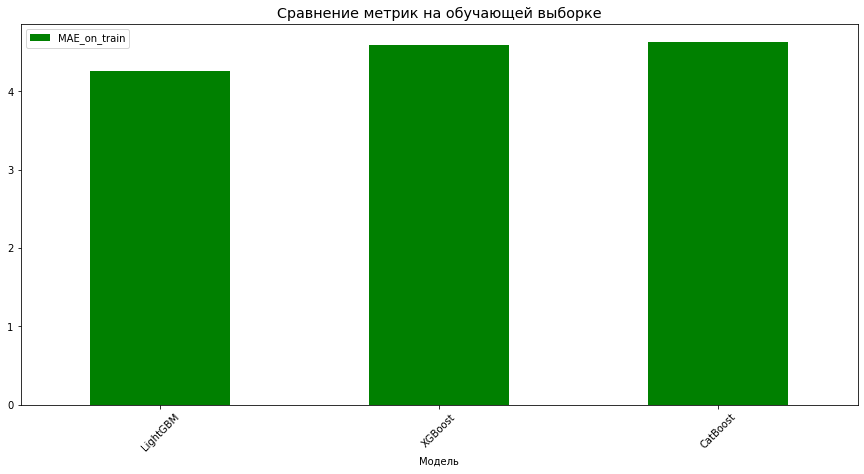

In [40]:
all_names = pd.DataFrame({'names':['LightGBM', 'XGBoost', 'CatBoost']})
analisys = pd.concat([analisys, all_names], axis=1, join='inner')
display(analisys)

analisys.plot.bar(y='MAE_model', x='names', rot=45, figsize=(15,7), color='orange')
plt.title('Сравнение метрик моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

analisys.plot.bar(y='MAE_on_train', x='names', rot=45, figsize=(15,7), color='green')
plt.title('Сравнение метрик на обучающей выборке', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

Так как время обучения не было первостепенной задачей, то наилучшие показатели имеет модель CatBoost, которую используем для теста

In [41]:
predicted = cat_random.predict(test_features)
mae_on_test = mean_absolute_error(test_target, predicted)
print('MAE на тестовой выборке при использовании GridSearchCV:', mae_on_test)

MAE на тестовой выборке при использовании GridSearchCV: 6.709112930563728


## Проверка модели на адекватность

In [42]:
dummy_model = DummyRegressor() 
dummy_model.fit(train_features, train_target) 


dummy_predict = dummy_model.predict(test_features)

print('MAE на тестовой выборке:', mean_absolute_error(test_target, dummy_predict)) 

MAE на тестовой выборке: 8.006890596258367


Видно, что Dummy модель показывает результат хуже, поэтому модель прошла проверку на адекватность

<div style="background-color:MintCream; border:solid CadetBlue 2px; padding: 20px">
<b>Итоговый комментарий:</b> У тебя вышла отличная работа. Но есть пару моментов, которые стоит исправить, чтобы я могла принять работу.

* не стоит удалять партии, отсеянные по времени, я упомянула на встрече, что, к сожалению, датчики рассинхронизированы
* не стоит использовать key для обучения моделей 
    
В остальном все отлично.
<div>

<div style="background-color:MintCream; border:solid CadetBlue 2px; padding: 20px">
<b>Итоговый комментарий v2:</b> Принимаю работу. Поздравляю, ты сдал первым из группы.
<div>

## Отчёт

* Все пункты предложенного плана проекта были выполнены
* В ходе работы возникли трудности с маленьким количеством данных, число партии оказалось очень мало, из-за чего метрика может быть неверной, также показалась затруднительной работа с выбросами.
* Ключевые шаги: Исследовательский анализ данных, предобработка данных, объединение данных, обучение моделей и поиск гипперпараметров, выбор лучшей модели, проверка на адекватность
* В ходе работы использовались такие признаки как начальная температура в партии, объём добавленных сыпучих и проволочных материалов (для редкоиспользуемых материалов посчитана их сумма и количество добавок), также использовалась рассчитанная энергия, которая получилась из полной мощности и времени нагрева, а именно признаки `temp_first`, `Bulk 12`, `Bulk 14`, `Bulk 15`, `count_bulk`, `sum_bulk`, `Wire 1`,	`count_wire`, `sum_wire`, `Энергия`, `Газ 1`.
* Лучшей оказалась модель CatBoost, с параметрами learning_rate = 0.01, max_depth = 7
* Итоговая метрика на тестовой выборке равна 6.7, что соответствует требованию заказчика <6.8